In [1]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
from generator_functions import random_uni_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import apply_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import kersize_samplingYX,feasibleApp_samplingYX_perbatch_cuda,feasibleApp_samplingYX_linear_cuda ,target_distances_samplingYX_precomputedFA_cuda_V2, avgLB_samplingYX
from accuracy_bounds.inverseproblems.utils import torch_sparse_to_scipy_csr, torch_csr_to_scipy


# Tests

## Toy example 1 : 3D ball

In [2]:

# Toy example 1
num_points = 3000
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 1000
input_target_pairs = 3000

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
    feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
    feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

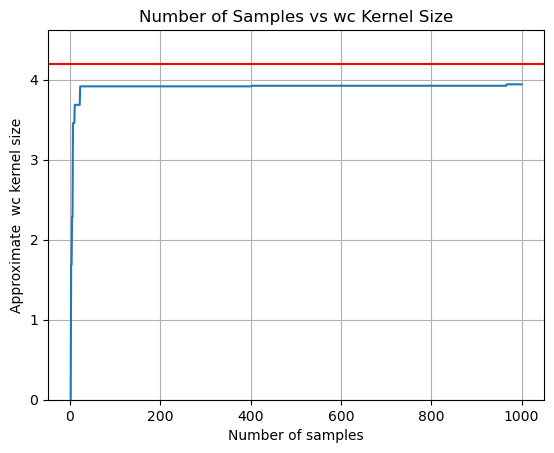

Total Max Kernel Size: 3.942548125489818
Analytical Kernel Size: 4.2
Relative Error: -0.06129806535956717


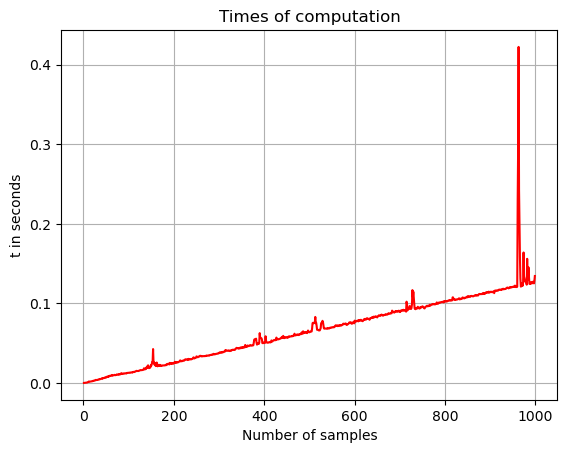

The last kernel size computation took 0.134359 seconds


In [3]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, np.arange(2, max_k+1))

plot_times_comput(list(range(1,max_k,1)), times_comput)


In [4]:
# Step 2: Compute worst-case kernel sizes with symmetry assumption:
worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:input_target_pairs], target_data, p_1, p_2, p, 2*epsilon)

worstcase_kersize_sym_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    worstcase_kersize_sym_list.append(worstcase_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize_sym, worstcase_kersize_sym_list, wc_kernel_size_analytical, np.arange(2, max_k+1))
plot_times_comput(list(range(1,max_k,1)), times_comput)

/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute.py:7: SyntaxWarning: invalid escape sequence '\m'
  """
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute.py:56: SyntaxWarning: invalid escape sequence '\m'
  """
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute.py:113: SyntaxWarning: invalid escape sequence '\m'
  """
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute.py:136: SyntaxWarning: invalid escape sequence '\m'
  """
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute.py:162: SyntaxWarning: invalid escape sequence '\m'
  """
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverse

KeyboardInterrupt: 

### Worst-case kernel size for linear forward model with additive noise, parallelized

In [ ]:
#batch_size = 100

#input_loader1 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
#input_loader2 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
#target_loader1 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
#target_loader2 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False) 

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


First test the 2 ways of computing feasible appartenance

In [ ]:
#t0 = time.time()
#feas_app_1 = feasibleApp_samplingYX_perbatch_cuda(input_data=input_loader1, forwarded_target= input_loader2, p_Y=2, epsilon=epsilon)
#t1 = time.time()
#feas_app_2 = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=2, epsilon= epsilon, batchsize=50)
#t2 = time.time()

#print(f'Per batch : tool {t1-t0:.4f} seconds')
# print(f'With candidate selection : {t2-t1:.4f} seconds')


In [ ]:
#delta = feas_app_1 - feas_app_1.to(dtype=feas_app_1.dtype)
#print(f'Difference between the computations {delta.sum()}')

Then, test the worst-case kernel size computation with one of the two feasible appertinance matrix approaches and both precomputed target distances.

In [ ]:
max_k = 1000
batch_size = 10
wc_kersizes = []
times_comput_FA = []
times_comput_WC = []

for k in tqdm(range(100,max_k,100)):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= 2*epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize= k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    wc_kersize_k = kersize_samplingYX(distsXX, feasible_appartenance)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, list(range(100,max_k,100)))



  0%|          | 0/1 [02:53<?, ?it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

### Average kernel size

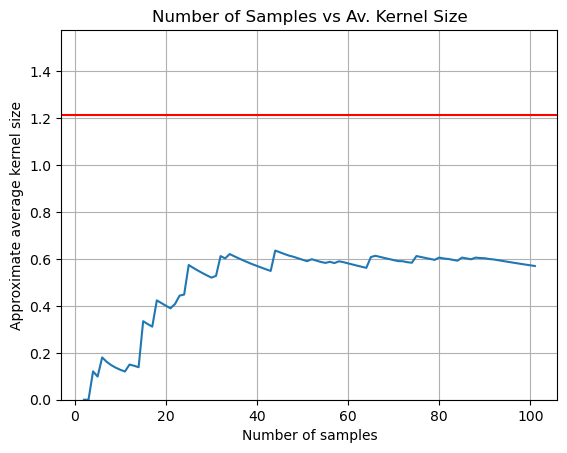

Total Max Kernel Size: 0.5702545261555658
Analytical Kernel Size: 1.2124355652982142
Relative Error: -0.5296619940249737


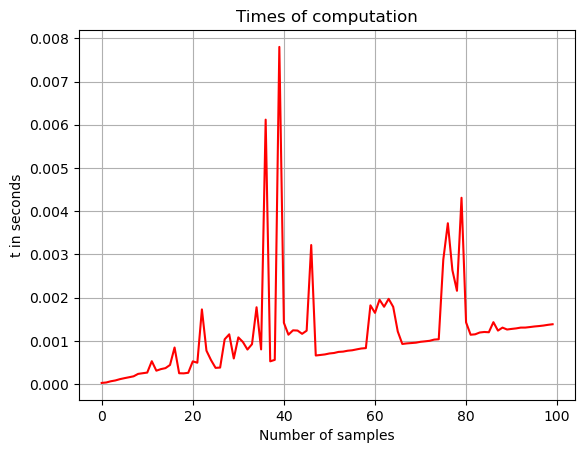

The last kernel size computation took 0.001386 seconds


In [ ]:
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(0,max_k,1)), times_comput)

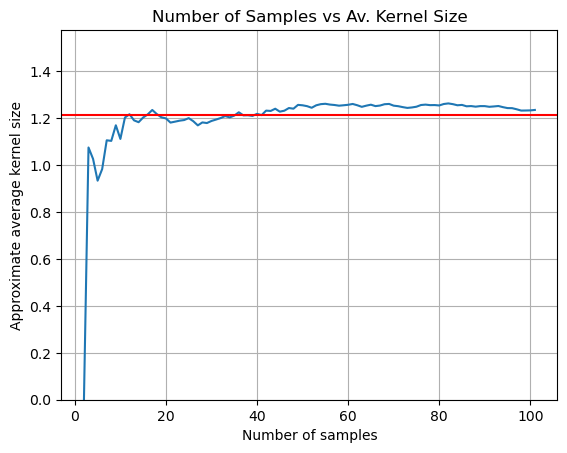

Total Max Kernel Size: 1.2357419986723037
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.01922282226054383


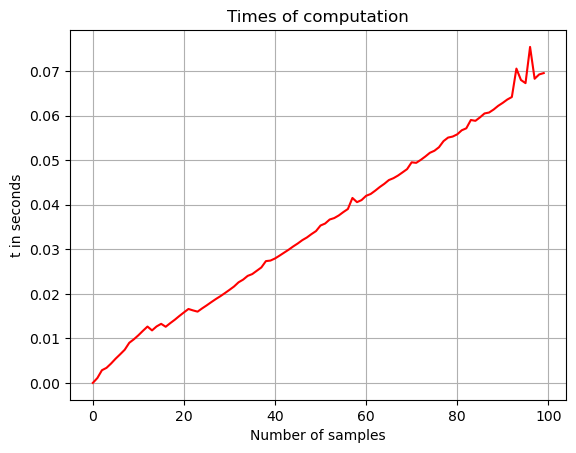

The last kernel size computation took 0.069549 seconds


In [ ]:
# Step 2: Compute average symmetric kernel sizes:
average_kersize_sym = average_kernelsize_sym(A, input_data, target_data, p_1, p_2, p, epsilon)

average_kersize_sym_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize_sym =  average_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    average_kersize_sym_list.append(average_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize_sym,average_kersize_sym_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(0,max_k,1)), times_comput)

### Average kernel size for linear forward model with additive noise, parallelized

  0%|          | 0/9 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:36: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  common_feasible = feasible_appartenance@(feasible_appartenance.transpose(0, 1))


 11%|█         | 1/9 [01:55<15:27, 115.88s/it]

 22%|██▏       | 2/9 [03:47<13:12, 113.19s/it]

 33%|███▎      | 3/9 [05:41<11:21, 113.55s/it]

 44%|████▍     | 4/9 [07:33<09:25, 113.18s/it]

 56%|█████▌    | 5/9 [09:26<07:32, 113.05s/it]

 67%|██████▋   | 6/9 [11:20<05:39, 113.19s/it]

 78%|███████▊  | 7/9 [13:14<03:47, 113.51s/it]

 89%|████████▉ | 8/9 [15:08<01:53, 113.63s/it]

100%|██████████| 9/9 [17:03<00:00, 113.69s/it]


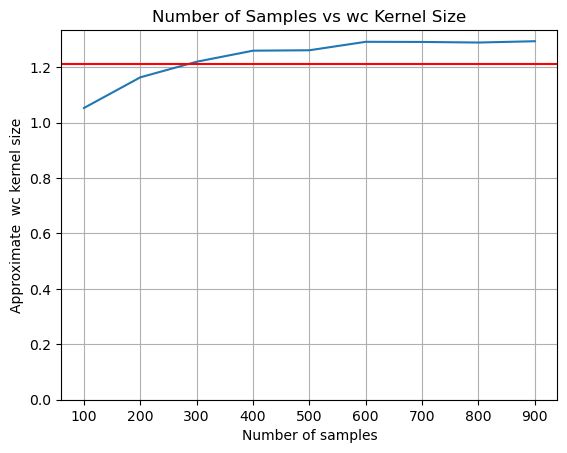

Total Max Kernel Size: 1.2936136268550917
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.06695453670307897


In [ ]:
max_k = 1000
batch_size = 10
av_kersizes = []
times_comput_FA = []
times_comput_AV = []

for k in tqdm(range(100,max_k,100)):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= 2*epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize= k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    av_kersize_k = avgLB_samplingYX(distsXX, feasible_appartenance, p_X=2)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_AV.append(t2-t1)
    av_kersizes.append(av_kersize_k)

av_kersizef = av_kersizes[-1]

plot_wckersize_conv(av_kersizef, av_kersizes, av_kernel_size_analytical, list(range(100,max_k,100)))